IMPORT LIBRARY

In [1]:
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import json
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

#importing the dataset
with open('data train.json') as content:
  data1 = json.load(content)

IMPORT DATASET

In [2]:
# Mendapatkan semua data ke dalam list
label = []
inputs = []
tanggapan = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data1['intensi']:
    tanggapan[intent['label']] = intent['tanggapan']
    for lines in intent['pola']:
        inputs.append(lines)
        label.append(intent['label'])
        for pattern in intent['pola']:
            w = pattern.split()  # Split the text into words
            words.extend(w)
            documents.append((w, intent['label']))
            # add to our classes list
            if intent['label'] not in classes:
                classes.append(intent['label'])


In [3]:
# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":label})

REMOVE PUNCTUATION

In [4]:
#removing punctuations
import string
data['patterns'] = data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['patterns'] = data['patterns'].apply(lambda wrd: ''.join(wrd))

STEMMING

In [5]:
#Stemming
factory = StemmerFactory()
stemmer = factory.create_stemmer()
ignore_words = []  # Add any words you want to ignore
data['patterns'] = data['patterns'].apply(lambda x: ' '.join([stemmer.stem(w.lower()) for w in x.split() if w not in ignore_words]))

# Display the updated DataFrame
print(data)

                                               patterns              tags
0                                                 hallo             salam
1                                                   hai             salam
2                                                  halo             salam
3                                                   hei             salam
4                                                    hi             salam
...                                                 ...               ...
1560    berapa lama jalan kaki dari halte bus ke museum  AR_museum_kereta
1561          apakah ada henti ojek online dekat museum  AR_museum_kereta
1562                apakah mudah temu becak tuju museum  AR_museum_kereta
1563  berapa tarif parkir untuk kendara pribadi di m...  AR_museum_kereta
1564   bagaimana cara ke museum jika saya bawa keluarga  AR_museum_kereta

[1565 rows x 2 columns]


TF IDF

In [6]:
# FIT CUSTOM 
#TOKENIZATION dan menyimpannya di dalam dict
# Input : set of documents
# Output: word, dimension number pair for each word as a python dictionary
def fit_custom(dataset):
  unique_words = []
  for row in dataset:
    for word in row.split(" "):
      if len(word)>=2 and word not in unique_words:
        unique_words.append(word) # Add each unique word of length>2 to the list
  unique_words.sort()
  word_dimension_dict = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
  return word_dimension_dict

word_dimension_dict = fit_custom(data['patterns'])
# print(word_dimension_dict)

In [7]:
print(word_dimension_dict)

{'02': 0, '1867': 1, '1942': 2, '1945': 3, '2006': 4, 'abadi': 5, 'acara': 6, 'acaraacara': 7, 'ada': 8, 'adalah': 9, 'adat': 10, 'adha': 11, 'adi': 12, 'adisucipto': 13, 'agam': 14, 'agama': 15, 'aja': 16, 'ajar': 17, 'akademis': 18, 'akan': 19, 'akhir': 20, 'akses': 21, 'aksesibilitas': 22, 'aku': 23, 'akun': 24, 'alam': 25, 'alamat': 26, 'alami': 27, 'alas': 28, 'alternatif': 29, 'alunalun': 30, 'aman': 31, 'ambil': 32, 'anak': 33, 'anakanak': 34, 'ancam': 35, 'anda': 36, 'andong': 37, 'anggap': 38, 'anggar': 39, 'anggota': 40, 'angkut': 41, 'antar': 42, 'antara': 43, 'antarjemput': 44, 'antarwisata': 45, 'apa': 46, 'apakah': 47, 'api': 48, 'aplikasi': 49, 'arah': 50, 'area': 51, 'arsitektur': 52, 'arti': 53, 'asa': 54, 'asal': 55, 'asalmuasal': 56, 'asalusul': 57, 'asing': 58, 'asli': 59, 'atas': 60, 'atau': 61, 'atraksi': 62, 'atur': 63, 'awal': 64, 'backpacker': 65, 'bagai': 66, 'bagaimana': 67, 'bagi': 68, 'bagus': 69, 'bai': 70, 'baik': 71, 'balik': 72, 'balita': 73, 'bandara':

SAVE WORDS

In [8]:
# Specify the file path where you want to save the dictionary
file_path = 'word_dimension_dict.json'

# Save the dictionary to a JSON file
with open(file_path, 'w') as json_file:
    json.dump(word_dimension_dict, json_file)

In [9]:
#MENGHITUNG SETIAP TERM YANG MUNCUL DI DATASET
# Defining an utility Function to calculate the number of times a word appears in a whole dataset
def count_of_word_in_whole_dataset(dataset, word):
  count = 0
  for row in dataset:
    if word in row:
      count = count+1
  return count

In [10]:
# MENGHITUNG TF IDF DI DALAM DATASET
def transform_custom(dataset, word_dimension_dict):
    rows = []
    columns = []
    values = []

    for idx, row in enumerate(dataset):  # for each document in the dataset
        # it will return a dict type object where key is the word and values is its frequency, {word:frequency}
        word_freq = dict(Counter(row.split()))
        # for every unique word in the document
        for word, freq in word_freq.items():
            if len(word) < 2:
                continue
            # we will check if it's there in the word_dimension_dictionary that we built in fit_custom() function
            # dict.get() function will return the values, if the key doesn't exist it will return -1
            col_index = word_dimension_dict.get(word, -1)  # retrieving the dimension number of a word
            if col_index != -1:
                # we are storing the index of the document
                rows.append(idx)
                # we are storing the dimensions of the word
                columns.append(col_index)
                # computes TF value for each word, freq of each word / total words in a document
                # computes count_of_word_in_whole_dataset value for each word=log(total no. of docs / no. of times a word is present in a doc via count_of_word_in_whole_dataset()

                # Now just multiply TF with count_of_word_in_whole_dataset
                # Below formulae to exactly replicate sklearn's formulae for tf-df calculation
                # See - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
                # If ``smooth_idf=True`` (the default), the constant "1" is added to the
                # numerator and denominator of the idf as if an extra document was seen
                # containing every term in the collection exactly once, which prevents
                # zero divisions: idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1.
                # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1340
                tf_idf_value = (freq / len(row.split())) * (
                        1 + (np.log((1 + len(dataset)) / (1 + count_of_word_in_whole_dataset(dataset, word)))))

                # but if smooth_idf=False then the following formulae would have been applied
                # val = (freq/len(row.split()))*(1 + (  np.log( (int(len(dataset)) ) / (count_of_word_in_whole_dataset(dataset, word) ))))

                values.append(tf_idf_value)

    sparse_matrix = csr_matrix((values, (rows, columns)), shape=(len(dataset), len(word_dimension_dict)))

    # As noted earlier, in scikit-learn this output is normalized using L2 normalization. scikit-learn does this by default.
    # So we have to do that as well to match with scikit-learn
    # normalize() function will apply ‘l2’, normalization by default
    # The 'norm' parameter to use to normalize each non zero sample
    # (or each non-zero feature if axis is 0).
    # https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
    final_normalized_output = normalize(sparse_matrix)

    return final_normalized_output

In [11]:
x = transform_custom(data['patterns'], word_dimension_dict)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
x_train = x.toarray()

In [12]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
y_train = data['tags']
y_train = np.array(y_train)
y_train

array(['salam', 'salam', 'salam', ..., 'AR_museum_kereta',
       'AR_museum_kereta', 'AR_museum_kereta'], dtype=object)

SPLIT DATA

In [14]:
# Step 1: Import necessary libraries
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Step 3: Check the shapes of the resulting sets
print("Training set shapes:", x_train.shape, y_train.shape)# Step 3: Check the shapes of the resulting sets
print("Training set shapes:", x_test.shape, y_test.shape)

Training set shapes: (1252, 755) (1252,)
Training set shapes: (313, 755) (313,)


MODEL

In [15]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


In [16]:
# Assuming x_train and y_train are your data
param_grid = {'C': [0.1, 1, 10], 'kernel': ['sigmoid', 'rbf']}
svm_model = SVC(probability=True)
model = GridSearchCV(svm_model, param_grid, cv=5)
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'kernel': ['sigmoid', 'rbf']})

SAVE MODEL

In [17]:
import joblib

# Save the entire GridSearchCV object
joblib.dump(model, 'grid_search_model.pkl')

['grid_search_model.pkl']

In [18]:
# Make predictions
y_pred = model.predict(x_test)

In [19]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9616613418530351


In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

  AP_keraton_yogyakarta       1.00      1.00      1.00         8
   AR_benteng_vredeburg       1.00      1.00      1.00         5
       AR_jogja_kembali       1.00      1.00      1.00         9
           AR_kelenteng       0.92      0.86      0.89        14
  AR_keraton_yogyakarta       1.00      1.00      1.00        11
       AR_museum_kereta       0.89      1.00      0.94         8
     AR_situs_tamansari       1.00      0.92      0.96        12
    AR_situs_warungboto       1.00      1.00      1.00        12
   SS_benteng_vredeburg       1.00      1.00      1.00         9
       SS_jogja_kembali       1.00      1.00      1.00         9
           SS_kelenteng       0.94      0.85      0.89        20
    SS_keraton_kotagede       0.91      1.00      0.95        10
  SS_keraton_yogyakarta       1.00      0.71      0.83         7
       SS_museum_kereta       1.00      1.00      1.00         8
     SS_situs_tamansari 

c:\Users\andhi\miniconda3\envs\chatbot\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andhi\miniconda3\envs\chatbot\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\andhi\miniconda3\envs\chatbot\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


VISUALISASI

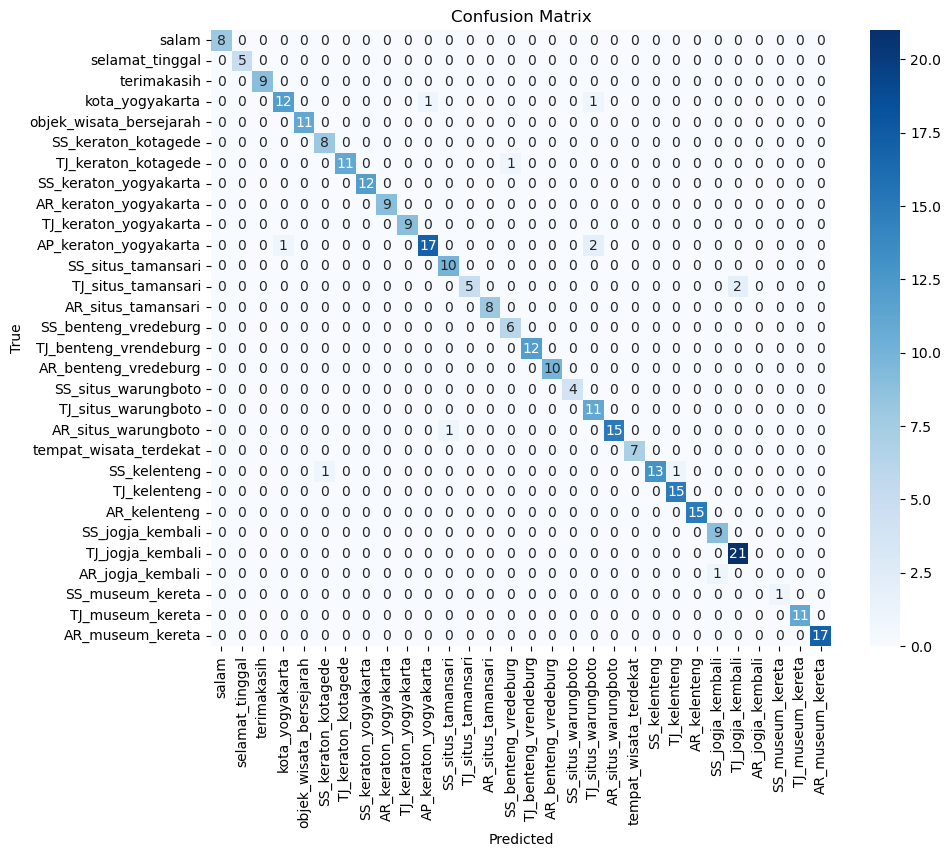

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test contains the true labels and y_pred contains the predicted labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=data['tags'].unique(), yticklabels=data['tags'].unique())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

TESTING LOGIC

In [22]:
# # Chatbot testing logic
# while True:
#     user_input = input('👨‍🦰 Kamu: ')

#     if "goodbye" in user_input:
#         print("🤖 KadekBot: Goodbye!")
#         break

#     # Preprocess user input
#     user_input = [ltrs.lower() for ltrs in user_input if ltrs not in string.punctuation]
#     user_input = ''.join(user_input)

#     # Stemming
#     factory = StemmerFactory()
#     stemmer = factory.create_stemmer()
#     ignore_words = []  # Add any words you want to ignore
#     user_input = ' '.join([stemmer.stem(w.lower()) for w in user_input.split() if w not in ignore_words])
      
#     # Transform the user input using the same word_dimension_dict
#     user_input_transformed = transform_custom([user_input], word_dimension_dict).toarray()
    
#     # # Use the trained model to predict the response
#     # response_label = model.predict(user_input_transformed)[0]

#     # Use the trained model to predict the response label and probabilities
#     response_label = model.predict(user_input_transformed)[0]
#     response_probabilities = model.predict_proba(user_input_transformed)[0]
#     # Find the index of the maximum probability
#     max_probability_index = np.argmax(response_probabilities)

#     # Display the predicted label and probabilities
#     print("Predicted Label:", response_label)
#     print("Probability Estimates:", response_probabilities)
#     # Display the predicted label with the maximum probability
#     print("Predicted Label with Max Probability:", max_probability_index)

#     # # Display the predicted label
#     # print("Predicted Label:", response_label)
#     # # Fetch the response for the predicted label from the tanggapan dictionary
#     # response_data = tanggapan.get(response_label, "No valid response found for the predicted label " + response_label + ".")

#     # print("🤖 KadekBot:", response_data[0])
#     # Check if the maximum probability is greater than the threshold (0.5)
#     if response_probabilities[max_probability_index] > 0.3:
#         # Display the predicted label
#         print("Predicted Label:", response_label)
#         # Fetch the response for the predicted label from the tanggapan dictionary
#         response_data = tanggapan.get(response_label, "No valid response found for the predicted label " + response_label + ".")
#         print("🤖 KadekBot:", response_data[0])
#     else:
#         print("maaf kata yang anda masukkan belum terdaftar silahkan masukkan pertanyaan lainnya")
